In [1]:
spark

In [2]:
dir0 = '/home/cloudera/2.kkbox_churn/data01/big_table_01/'
infile = dir0 + 'all-features_has-expired_auto-renew-0'

df0 = spark.read.format('parquet').load(infile)

In [3]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- city: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- days_since_init_regist: integer (nullable = true)
 |-- init_date: string (nullable = true)
 |-- final_date: string (nullable = true)
 |-- gaps_count: integer (nullable = true)
 |-- total_gap_len: integer (nullable = true)
 |-- has_long_gap: boolean (nullable = true)
 |-- has_expired: boolean (nullable = true)
 |-- last_pay_method: string (nullable = true)
 |-- last_plan_days: integer (nullable = true)
 |-- last_list_price: integer (nullable = true)
 |-- last_actual_paid: integer (nullable = true)
 |-- last_discount: integer (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- actual_paid_cnt_uniq: integer (nullable = true)
 |-- actual_paid_mode: integer (nullable = true)
 |-- auto_renew_cnt_uniq: integer (nullable = true)
 |-- auto_renew_mode: boolean (nullable = true)

In [4]:
df0.count()

32733

In [5]:
df0.columns

['msno',
 'city',
 'age',
 'gender',
 'registered_via',
 'days_since_init_regist',
 'init_date',
 'final_date',
 'gaps_count',
 'total_gap_len',
 'has_long_gap',
 'has_expired',
 'last_pay_method',
 'last_plan_days',
 'last_list_price',
 'last_actual_paid',
 'last_discount',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'actual_paid_mode',
 'auto_renew_cnt_uniq',
 'auto_renew_mode',
 'discount_cnt_uniq',
 'discount_mode',
 'list_price_cnt_uniq',
 'list_price_mode',
 'pay_method_cnt_uniq',
 'pay_method_mode',
 'plan_days_cnt_uniq',
 'plan_days_mode',
 'actual_paid_sum',
 'actual_paid_per_sub_day',
 'discount_sum',
 'discount_per_sub_day',
 'list_price_sum',
 'list_price_per_sub_day',
 'last12WeekOnLine',
 'w12_M25',
 'w12_M50',
 'w12_M75',
 'w12_M985',
 'w12_M100',
 'w12_Munq',
 'w12_Msecs',
 'w12_Mtotal',
 'w12_M25_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal',
 'w12_M25M50M75_D_Mtotal',
 'w12_M985M100_D_Mtotal',

In [15]:
df0.groupBy('is_churn').count().show()

+--------+-----+
|is_churn|count|
+--------+-----+
|    true|18031|
|   false|14702|
+--------+-----+



In [9]:
import re

group_members = ['city', 'age', 'gender', 'registered_via', 'days_since_init_regist']
group_trans = ['init_date', 'final_date', 'gaps_count', 'total_gap_len', 'has_long_gap',
               'has_expired', 'last_pay_method', 'last_plan_days', 'last_list_price', 'last_actual_paid',
               'last_discount', 'last_paid_per_day', 'actual_paid_cnt_uniq', 'actual_paid_mode',
               'auto_renew_cnt_uniq', 'auto_renew_mode', 'discount_cnt_uniq', 'discount_mode',
               'list_price_cnt_uniq', 'list_price_mode', 'pay_method_cnt_uniq', 'pay_method_mode',
               'plan_days_cnt_uniq', 'plan_days_mode', 'actual_paid_sum', 'actual_paid_per_sub_day',
               'discount_sum', 'discount_per_sub_day', 'list_price_sum', 'list_price_per_sub_day']
group_userlogs = [c  for c in df0.columns 
                  if re.match('last\d+WeekOnLine', c) or re.match('w\d+_', c)]

# [utility functions]

In [115]:
def plot_against_categorical(df, cat_field, ax, sort_as_int=False):
    df_ = df.crosstab(cat_field, 'is_churn') \
         .withColumnRenamed('false' ,'not chrun') \
         .withColumnRenamed('true' ,'chrun')
    if sort_as_int:
        df_ = df_.sort(col(cat_field+'_is_churn').cast('int'))
        
    tb = df_.toPandas().set_index(cat_field+'_is_churn')
    tb.plot.bar(ax=ax, alpha=0.7)

    ax.set(xlabel=cat_field, ylabel='members count')

In [127]:
def plot_scatter(df, field_x, field_y, ax, alpha=0.8):
    tb = df.select(field_x, field_y).toPandas()
    tb.plot.scatter(ax=ax, x=field_x, y=field_y, alpha=alpha)

In [136]:
import matplotlib.pyplot as plt
def plot_against_continuous(df, cont_field, bins, value_range):
    ''' Returns (fig, axes) '''
    arr_is_churn = np.array(df1.where('is_churn').select(cont_field).collect())
    arr_not_churn = np.array(df1.where(~col('is_churn')).select(cont_field).collect())

    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].hist(arr_not_churn, bins, range=value_range)
    axes[1].hist(arr_is_churn, bins, range=value_range)

    axes[0].set(title='not churn', xlim=value_range, xlabel=cont_field, ylabel='members count')
    axes[1].set(title='churn', xlim=value_range, xlabel=cont_field, ylabel='members count')

    fig.subplots_adjust(hspace=0.5)
    return (fig, axes)

# member data

In [112]:
df1 = df0.select(['msno', 'is_churn'] + group_members)

In [114]:
df1.show(2)

+--------------------+--------+----+---+------+--------------+----------------------+
|                msno|is_churn|city|age|gender|registered_via|days_since_init_regist|
+--------------------+--------+----+---+------+--------------+----------------------+
|+2GgJdINpS53hcABf...|   false|   5| 41|female|             9|                  3749|
|+2gGE8RHPZ013pQs4...|    true|  18| 30|female|             9|                  2264|
+--------------------+--------+----+---+------+--------------+----------------------+
only showing top 2 rows



## days_since_init_regist

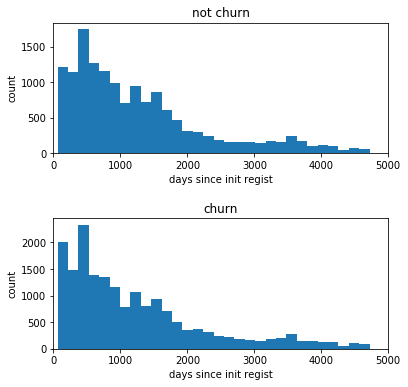

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

arr_dsir_is_churn = np.array(df1.where('is_churn').select('days_since_init_regist').collect())
arr_dsir_not_churn = np.array(df1.where(~col('is_churn')).select('days_since_init_regist').collect())

fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_dsir_not_churn, 30)
axes[1].hist(arr_dsir_is_churn, 30)

axes[0].set(title='not churn', xlim=[0,5000], xlabel='days since init regist', ylabel='count')
axes[1].set(title='churn', xlim=[0,5000], xlabel='days since init regist', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

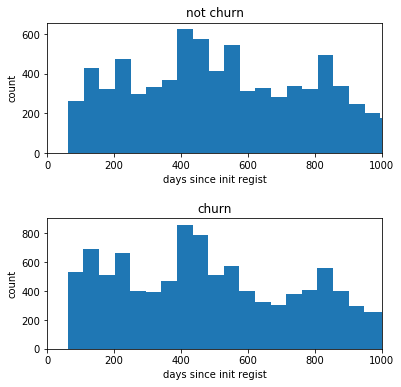

In [77]:
fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_dsir_not_churn, 100)
axes[1].hist(arr_dsir_is_churn, 100)

axes[0].set(title='not churn', xlim=[0,1000], xlabel='days since init regist', ylabel='count')
axes[1].set(title='churn', xlim=[0,1000], xlabel='days since init regist', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

## registered_via

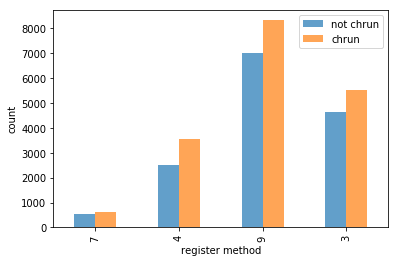

In [75]:
df = df1.crosstab('registered_via', 'is_churn') \
     .withColumnRenamed('false' ,'not chrun') \
     .withColumnRenamed('true' ,'chrun')
tb = df.toPandas().set_index('registered_via_is_churn')

fig, ax = plt.subplots()
tb.plot.bar(ax=ax, alpha=0.7)

ax.set(xlabel='register method', ylabel='count')

plt.show()

## city

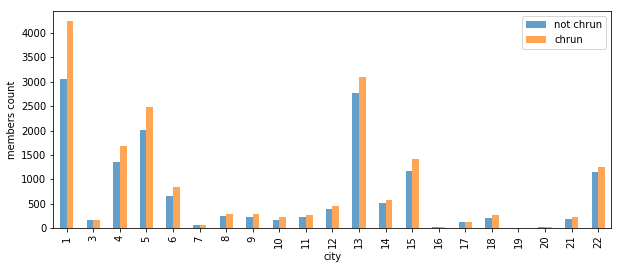

In [116]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'city', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

# transactions

In [117]:
df1 = df0.select(['msno', 'is_churn'] + group_trans)

In [88]:
print(df1.columns)

['msno', 'is_churn', 'init_date', 'final_date', 'gaps_count', 'total_gap_len', 'has_long_gap', 'has_expired', 'last_pay_method', 'last_plan_days', 'last_list_price', 'last_actual_paid', 'last_discount', 'last_paid_per_day', 'actual_paid_cnt_uniq', 'actual_paid_mode', 'auto_renew_cnt_uniq', 'auto_renew_mode', 'discount_cnt_uniq', 'discount_mode', 'list_price_cnt_uniq', 'list_price_mode', 'pay_method_cnt_uniq', 'pay_method_mode', 'plan_days_cnt_uniq', 'plan_days_mode', 'actual_paid_sum', 'actual_paid_per_sub_day', 'discount_sum', 'discount_per_sub_day', 'list_price_sum', 'list_price_per_sub_day']


## gaps

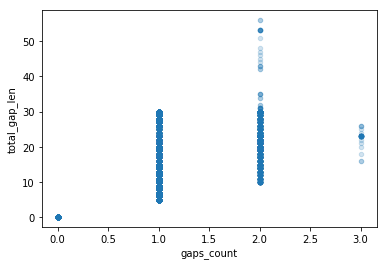

In [91]:
tb = df1.select('gaps_count', 'total_gap_len').toPandas()

fig, ax = plt.subplots()
tb.plot.scatter(ax=ax, x='gaps_count', y='total_gap_len', alpha=0.2)

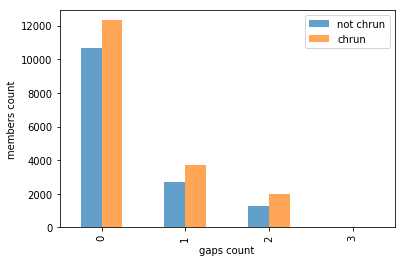

In [95]:
df = df1.crosstab('gaps_count', 'is_churn') \
     .withColumnRenamed('false' ,'not chrun').withColumnRenamed('true' ,'chrun') \
     .sort(col('gaps_count_is_churn'))
tb = df.toPandas().set_index('gaps_count_is_churn')

fig, ax = plt.subplots()
tb.plot.bar(ax=ax, alpha=0.7)

ax.set(xlabel='gaps count', ylabel='members count')

plt.show()

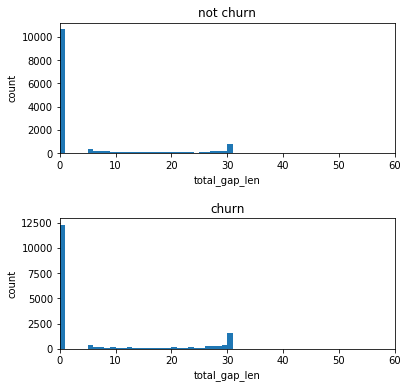

In [109]:
arr_is_churn = np.array(df1.where('is_churn').select('total_gap_len').collect())
arr_not_churn = np.array(df1.where(~col('is_churn')).select('total_gap_len').collect())

fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_not_churn, 60, range=(0,60))
axes[1].hist(arr_is_churn, 60, range=(0,60))

axes[0].set(title='not churn', xlim=[0,60], xlabel='total_gap_len', ylabel='count')
axes[1].set(title='churn', xlim=[0,60], xlabel='total_gap_len', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

In [104]:
df1.crosstab('has_long_gap', 'is_churn').show()

+---------------------+-----+-----+
|has_long_gap_is_churn|false| true|
+---------------------+-----+-----+
|                false|14702|18031|
+---------------------+-----+-----+



## last_pay_method

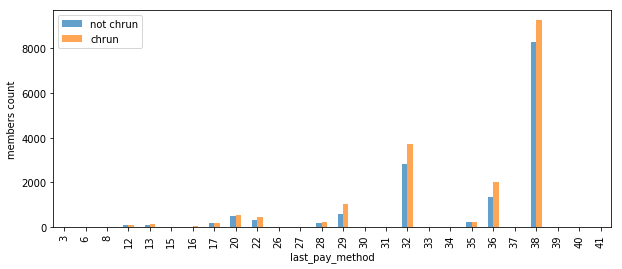

In [122]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last_pay_method', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## last_plan_days

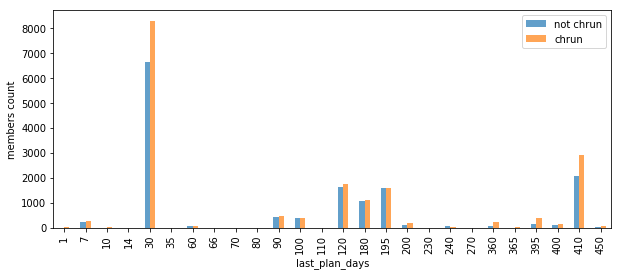

In [125]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last_plan_days', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## last_discount

In [134]:
df1.crosstab('last_discount', 'is_churn').show()

+----------------------+-----+-----+
|last_discount_is_churn|false| true|
+----------------------+-----+-----+
|                   149|   13|   11|
|                  -894|    0|    1|
|                     0|14689|18019|
+----------------------+-----+-----+



In [137]:
df1.select(max('last_paid_per_day')).show()

+----------------------+
|max(last_paid_per_day)|
+----------------------+
|                   6.0|
+----------------------+



## last_paid_per_day

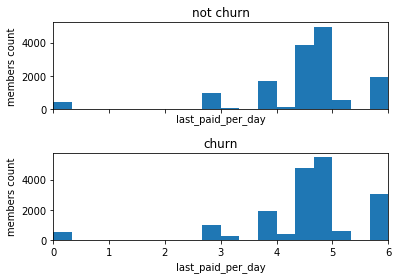

In [139]:
fig, axes = plot_against_continuous(df1, 'last_paid_per_day', 18, (0,6))
plt.show()

## discount_mode

In [140]:
df1.crosstab('discount_mode', 'is_churn').show()

+----------------------+-----+-----+
|discount_mode_is_churn|false| true|
+----------------------+-----+-----+
|                   149|    2|    8|
|                  -894|    0|    1|
|                     0|14700|18022|
+----------------------+-----+-----+



## list_price_cnt_uniq

In [142]:
df1.crosstab('list_price_cnt_uniq', 'is_churn').sort('list_price_cnt_uniq_is_churn').show()

+----------------------------+-----+-----+
|list_price_cnt_uniq_is_churn|false| true|
+----------------------------+-----+-----+
|                           1|13104|16095|
|                           2| 1536| 1852|
|                           3|   61|   83|
|                           4|    1|    1|
+----------------------------+-----+-----+



## pay_method_cnt_uniq

In [144]:
df1.crosstab('pay_method_cnt_uniq', 'is_churn').sort('pay_method_cnt_uniq_is_churn').show()

+----------------------------+-----+-----+
|pay_method_cnt_uniq_is_churn|false| true|
+----------------------------+-----+-----+
|                           1|13394|16363|
|                           2| 1258| 1593|
|                           3|   49|   75|
|                           4|    1|    0|
+----------------------------+-----+-----+



## pay_method_mode

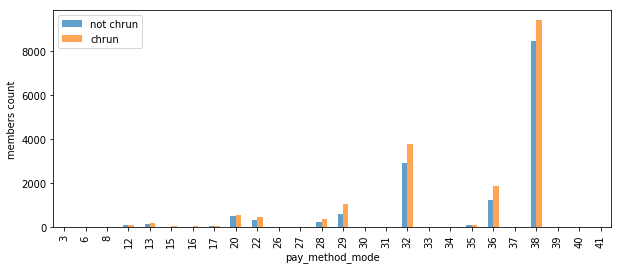

In [143]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'pay_method_mode', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## actual_paid_sum

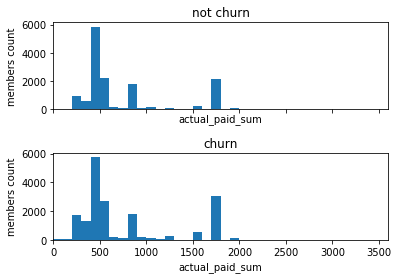

In [147]:
fig, axes = plot_against_continuous(df1, 'actual_paid_sum', 36, (0,3600))
plt.show()

## actual_paid_per_sub_day

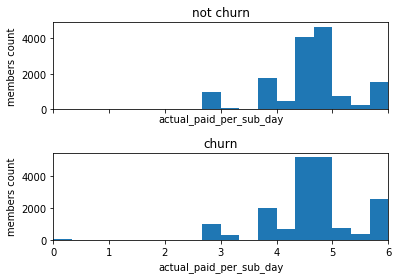

In [149]:
fig, axes = plot_against_continuous(df1, 'actual_paid_per_sub_day', 18, (0,6))
plt.show()

## discount_sum

In [152]:
df1.crosstab('discount_sum', 'is_churn').show()

+---------------------+-----+-----+
|discount_sum_is_churn|false| true|
+---------------------+-----+-----+
|                  149|   23|   21|
|                 -894|    0|    1|
|                    0|14679|18009|
+---------------------+-----+-----+



## list_price_sum

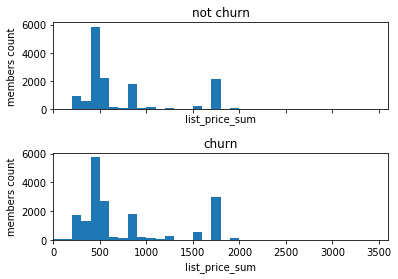

In [153]:
fig, axes = plot_against_continuous(df1, 'list_price_sum', 36, (0,3600))
plt.show()

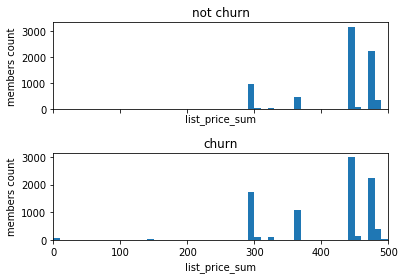

In [155]:
fig, axes = plot_against_continuous(df1, 'list_price_sum', 50, (0,500))
plt.show()

# user logs

In [174]:
from pyspark.sql.functions import when
df1 = df0.select(['msno', 'is_churn'] + group_userlogs) \
      .withColumn('w1_secs_per_song', when(col('w1_Mtotal').isNull() | col('w1_Msecs').isNull(), float('nan')) \
                                        .otherwise(col('w1_Msecs')/col('w1_Mtotal')))

## last 1 week

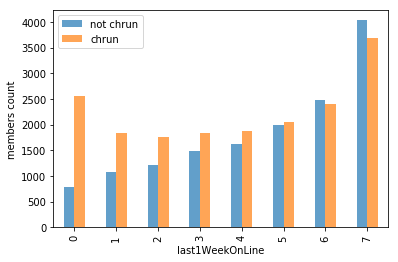

In [161]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last1WeekOnLine', ax, sort_as_int=True)
plt.show()

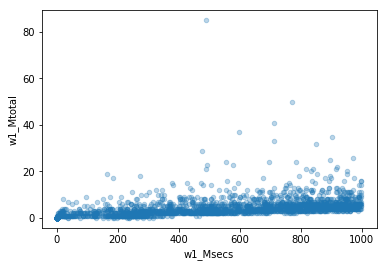

In [163]:
fig, ax = plt.subplots()
plot_scatter(df1, 'w1_Msecs', 'w1_Mtotal', ax, alpha=0.3)
plt.show()

In [179]:
df1.select('w1_Mtotal', 'w1_Msecs', 'w1_secs_per_song').show(40)

+---------+--------+------------------+
|w1_Mtotal|w1_Msecs|  w1_secs_per_song|
+---------+--------+------------------+
|       28|    null|               NaN|
|       28|    null|               NaN|
|        9|    null|               NaN|
|        0|       0|              null|
|        0|       0|              null|
|       68|    null|               NaN|
|       32|    null|               NaN|
|       26|    null|               NaN|
|       20|    null|               NaN|
|        6|     821|136.83333333333334|
|        9|    null|               NaN|
|       19|    null|               NaN|
|       21|    null|               NaN|
|       27|    null|               NaN|
|        5|    null|               NaN|
|       61|    null|               NaN|
|       24|    null|               NaN|
|       57|    null|               NaN|
|        9|    null|               NaN|
|       13|    null|               NaN|
|       50|    null|               NaN|
|        0|       0|              null|


TypeError: '>=' not supported between instances of 'NoneType' and 'float'

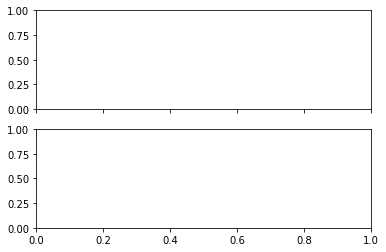

In [175]:
fig, axes = plot_against_continuous(df1, 'w1_secs_per_song', 31, (0,465))
plt.show()

In [166]:
print([c for c in df1.columns if c.startswith('w1_') or c.startswith('last1W')])

['last1WeekOnLine', 'w1_M25', 'w1_M50', 'w1_M75', 'w1_M985', 'w1_M100', 'w1_Munq', 'w1_Msecs', 'w1_Mtotal', 'w1_M25_D_Mtotal', 'w1_M50_D_Mtotal', 'w1_M75_D_Mtotal', 'w1_M985_D_Mtotal', 'w1_M100_D_Mtotal', 'w1_Munq_D_Mtotal', 'w1_M25M50M75_D_Mtotal', 'w1_M985M100_D_Mtotal', 'w1_M25M50_D_Mtotal', 'w1_M25_D_M50M75M985M100', 'w1_M25M50_D_M75M985M100', 'w1_M25M50M75_D_M985M100', 'w1_M25M50M75M985_D_M100', 'w1_secs_per_song']


In [167]:
df1.select(max('w1_secs_per_song')).show()

+---------------------+
|max(w1_secs_per_song)|
+---------------------+
|                465.0|
+---------------------+

